# Estimating the generalization performance of an iterative algorithm

along its trajectory

In a linear model $y_i = x_i^T\beta + \epsilon_i$ with true regression
vector $\beta\in\mathbb R^p$, noise $\epsilon_i\sim N(0,\sigma^2)$ and
feature matrix $X\in \mathbb R^{n\times p}$ with rows
$(x_i)_{i\in [n]}$, we are interested in estimationg the *generalization
error* of an iterative algorithm of the form for some function $g_t$ of
the two previous iterates and their gradients (here, with respect to the
square loss). The iterate and gradient at iteration $t-2$ are included
to allow for accelerated methods that require momentum.

The following example illustrates the estimator proposed in (Bellec and
Tan 2024).

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

n = 10000                   # sample size
p = 15000                   # dimension
s = 1000                    # sparsity
T = 100                     # number of iterations
eta = (1+np.sqrt(p/n))**-2 # learning rate
L = 1/eta                  # smoothness of the loss
lam = 0.01                 # tuning parameter
sigma = 1.5                # noise level

# true regression vector
beta = 15 * np.hstack([np.ones(s), np.zeros(p-s)]) / np.sqrt(n)

# data generation process
rng = np.random.default_rng(2025)
X = rng.standard_normal(size=(n, p)) # feature matrix
y = X @ beta + sigma * rng.standard_normal(size=(n, )) # signal + noise

## Proximal Gradient Descent

In the simple example below, we focus on the proximal gradient descent
(Parikh, Boyd, et al. 2014) iterates where $\eta>0$ is a learning rate
parameter, and the nonlinear function $g$ is the proximal operator of
the L1 norm with parameter $\eta \lambda$, namely, the soft-thresholding

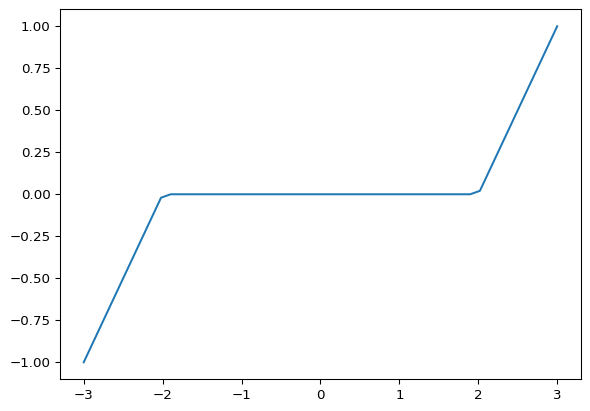

In [2]:
def soft(x, t):
    return np.sign(x)*np.clip(np.abs(x)-t, 0, None)

plt.plot(np.linspace(-3,3), soft(np.linspace(-3, 3), 2))

## Hutchinson’s trace approximation

We will use the following trick to efficiently estimate the trace of a
large matrix: if $R = (r_{ik})_{i\in[n],k=[m]}$ has iid symmetric
$\pm 1/\sqrt m$, then for $Q\in \mathbb R^{n\times n}$ the Hutchinson
approximation $\text{trace}(Q)\approx\text{trace}(R^TQR)/m$ holds with
$m$ of constant order provided $\|Q\|_F \lll \text{trace}(Q)$.

In [3]:
m = 10
r = rng.choice([-1.0, 1.0], size=(n, m)) / np.sqrt(m)

For instance, let us verify this approximation with a random matrix:

In [4]:
G = rng.normal(size=(n, n))
temporary_matrix = G.T @ np.diag(np.linspace(1, 10, num=n)) @ G

In [5]:
np.trace(temporary_matrix), np.trace(r.T @ temporary_matrix @ r)

(550122897.8034426, 550825944.5616682)

## Estimating the generalization error along the algorithm trajectory

We are now ready to compute the iterates of the proximal gradient
algorithm, as well as the estimate of its generalization error from
(Bellec and Tan 2024).

In [6]:
# initialization of arrays
F = np.zeros((n, T))                   # residuals
H = np.zeros((p, T), dtype=np.float16) # error vectors
bt = np.zeros_like(beta)               # iterate
F[:, 0] = y - X @ bt
H[:, 0] = bt - beta
A = np.zeros((T, T))                   # memory matrix
XTr = X.T @ r                          # r has iid Rademacher entries

for t in range(1, T):
    print(t, end="..")
    bt = soft(bt + eta * X.T @ (y-X@bt) /n, lam * eta)
    Dt = np.zeros(p, dtype=bool)
    Dt[np.nonzero(bt)[0]] = 1
    Dt = Dt.reshape((p, 1))
    if t >= 1:
        Rt = Dt * XTr if t == 1 else np.hstack([Dt * (Rt - (eta/n)*X.T @ ( X @ Rt)), Dt * XTr])
        A[t, :t] = np.trace((eta * XTr.T @ Rt / n).reshape((m, t, m)),
                            axis1=0, axis2=2)

    F[:, t] = y - X @ bt
    H[:, t] = bt - beta

M = np.linalg.solve(np.eye(T)-A/n, F.T).T
generalization_error = H.T @ H + np.ones((T, T))*sigma**2
generalization_error_estimate = M.T @ M/n

1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..

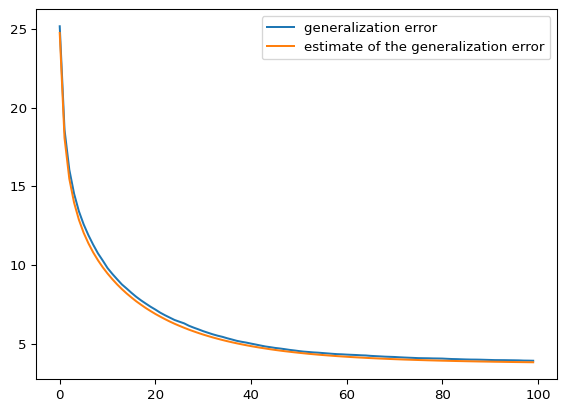

In [7]:
import pandas as pd
df = pd.DataFrame(np.column_stack([
          np.diag(generalization_error_estimate),
          np.diag(generalization_error),
]))
df.columns = ('generalization error', 'estimate of the generalization error')
df.plot()

In [8]:
df.round(2)

100 rows × 2 columns

Bellec, Pierre C, and Kai Tan. 2024. “Uncertainty Quantification for
Iterative Algorithms in Linear Models with Application to Early
Stopping.” *arXiv Preprint arXiv:2404.17856*.
<https://arxiv.org/pdf/2404.17856>.

Parikh, Neal, Stephen Boyd, et al. 2014. “Proximal Algorithms.”
*Foundations and Trends in Optimization* 1 (3): 127–239.